In [1]:
import re
import pandas as pd
import numpy as np
import string
import seaborn as sns
import matplotlib.pyplot as plt

import re, string, unicodedata 
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import WordNetLemmatizer, LancasterStemmer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tokenize.toktok import ToktokTokenizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from textblob import TextBlob
from textblob import Word
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from bs4 import BeautifulSoup

In [2]:
data = pd.read_csv("Amazon reviews Cleaned.csv")

In [3]:
review = data.copy()

In [4]:
review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399999 entries, 0 to 399998
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  399999 non-null  int64 
 1   Sentiment   399999 non-null  object
 2   Heading     399975 non-null  object
 3   Reviews     399999 non-null  object
dtypes: int64(1), object(3)
memory usage: 12.2+ MB


In [5]:
review.head()

,Unnamed: 0,Sentiment,Heading,Reviews
0,0,positive,One of the best game music soundtracks - for a...,Despite the fact that I have only played a sma...
1,1,negative,Batteries died within a year ...,I bought this charger in Jul 2003 and it worke...
2,2,positive,"works fine, but Maha Energy is better",Check out Maha Energy's website. Their Powerex...
3,3,positive,Great for the non-audiophile,Reviewed quite a bit of the combo players and ...
4,4,negative,DVD Player crapped out after one year,I also began having the incorrect disc problem...


In [6]:
review.Sentiment.value_counts()

Sentiment
negative    200000
positive    199999
Name: count, dtype: int64

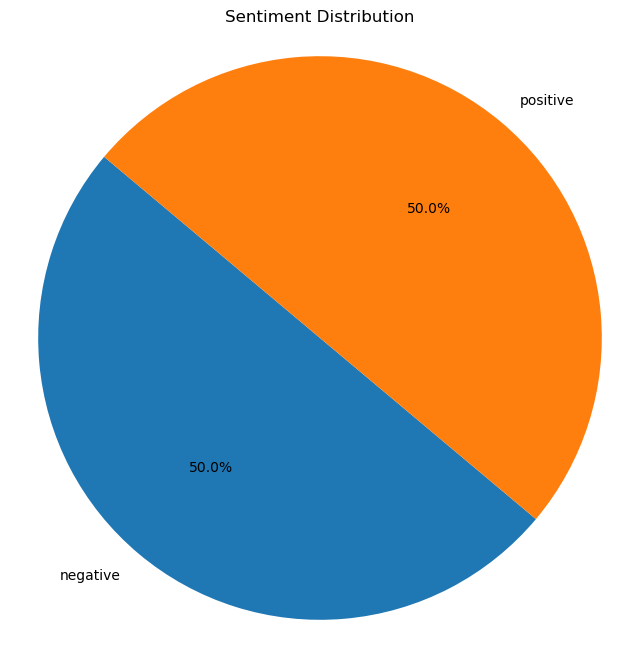

In [7]:
# Example sentiment data
sentiment_counts = review['Sentiment'].value_counts()

# Plotting a pie chart
plt.figure(figsize=(8, 8))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Sentiment Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show();

In [8]:
# Split the dataframe into positive and negative reviews
positive_reviews = review[review['Sentiment'] == 'positive']
negative_reviews = review[review['Sentiment'] == 'negative']

# Sample 1000 reviews from each
sampled_positive_reviews = positive_reviews.sample(n=1000, random_state=1)
sampled_negative_reviews = negative_reviews.sample(n=1000, random_state=1)

# Concatenate the samples to create the final dataset
df = pd.concat([sampled_positive_reviews, sampled_negative_reviews])

# Optionally shuffle the final dataset to mix positive and negative reviews
df = df.sample(frac=1, random_state=1).reset_index(drop=True)

# Check the result
print(df['Sentiment'].value_counts())

Sentiment
positive    1000
negative    1000
Name: count, dtype: int64


In [9]:
df.head()

,Unnamed: 0,Sentiment,Heading,Reviews
0,262972,positive,"Wonderful, Wonderful CD",I first saw Russell Watson in a concert in Eng...
1,327184,negative,A major disappointment,"After the incredible Screamadelica, I bought t..."
2,299674,negative,BORE ME SOMEMORE,BOUGHT HER ONLY FOR THE COLLECTION. BORING. WO...
3,306146,negative,Just awful.,We bought this for the diaper bag when my firs...
4,27783,negative,"Lots of mistakes, not thorough","If you're looking for bars in Prague, this is ..."


In [10]:
# Merging Heading and Reviews columns together
df['new_review'] = df['Heading'] + ' ' + df['Reviews']

In [11]:
df.head()

,Unnamed: 0,Sentiment,Heading,Reviews,new_review
0,262972,positive,"Wonderful, Wonderful CD",I first saw Russell Watson in a concert in Eng...,"Wonderful, Wonderful CD I first saw Russell Wa..."
1,327184,negative,A major disappointment,"After the incredible Screamadelica, I bought t...",A major disappointment After the incredible Sc...
2,299674,negative,BORE ME SOMEMORE,BOUGHT HER ONLY FOR THE COLLECTION. BORING. WO...,BORE ME SOMEMORE BOUGHT HER ONLY FOR THE COLLE...
3,306146,negative,Just awful.,We bought this for the diaper bag when my firs...,Just awful. We bought this for the diaper bag ...
4,27783,negative,"Lots of mistakes, not thorough","If you're looking for bars in Prague, this is ...","Lots of mistakes, not thorough If you're looki..."


In [12]:
df.columns

Index(['Unnamed: 0', 'Sentiment', 'Heading', 'Reviews', 'new_review'], dtype='object')

In [13]:
# Not working with the other columns with missing values for this project

df.drop(columns=['Unnamed: 0', 'Heading', 'Reviews'], inplace=True)

In [14]:
df.head()

,Sentiment,new_review
0,positive,"Wonderful, Wonderful CD I first saw Russell Wa..."
1,negative,A major disappointment After the incredible Sc...
2,negative,BORE ME SOMEMORE BOUGHT HER ONLY FOR THE COLLE...
3,negative,Just awful. We bought this for the diaper bag ...
4,negative,"Lots of mistakes, not thorough If you're looki..."


In [15]:
import nltk


In [16]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [17]:
# Clean text
def noiseremover(text):
    if not isinstance(text, str):
        return text
    text = re.sub('<.*?>', ' ', text)
    text = re.sub(r'https?://\S+|www\.\S+', ' ', text)
    text = re.sub('[^a-zA-Z0-9\s]', '', text)
    text = ''.join([i for i in text if not i.isdigit()])
    text = " ".join(filter(None, (re.compile(r'\D*\d').match(word) and '' or word for word in text.split())))
    return text

df['new_review'] = df['new_review'].apply(noiseremover)

df.head();

In [18]:
# Apply stemming
ps = PorterStemmer()
df['new_review'] = df['new_review'].apply(lambda x: ' '.join([ps.stem(word) for word in x.split()]))

In [19]:
# dropping the new_review column
#df.drop(columns=['new_review'], inplace=True)

In [20]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [21]:
# Remove stopwords
stopwords_list = stopwords.words('english')
stopwords_list.remove('no')
stopwords_list.remove('not')
tokenizer = ToktokTokenizer()

def removing_stopwords(text):
    tokens = tokenizer.tokenize(text)
    tokens = [i.strip() for i in tokens]
    return ' '.join([i for i in tokens if i.lower() not in stopwords_list])

df['new_review'] = df['new_review'].apply(removing_stopwords)

In [22]:
df.head()

,Sentiment,new_review
0,positive,wonder wonder cd first saw russel watson conce...
1,negative,major disappoint incred screamadelica bought t...
2,negative,bore somemor bought onli collect bore wouldnt ...
3,negative,aw bought thi diaper bag first wa readi potti ...
4,negative,lot mistak not thorough look bar pragu thi gui...


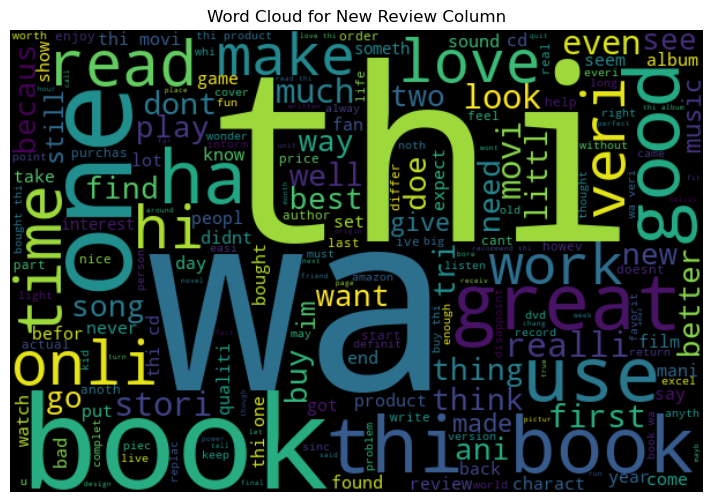

In [23]:
# Add additional stopwords
#additional_stopwords = ['thi', 'wa', 'hi', 'becaus','someth', 'amp']
#stopwords_list += additional_stopwords

from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all text in the 'new_review' column into a single string
text = ' '.join(df['new_review'])

# Generate word cloud
wordcloud = WordCloud(width=600, height=400, background_color='black').generate(text)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for New Review Column')
plt.show();

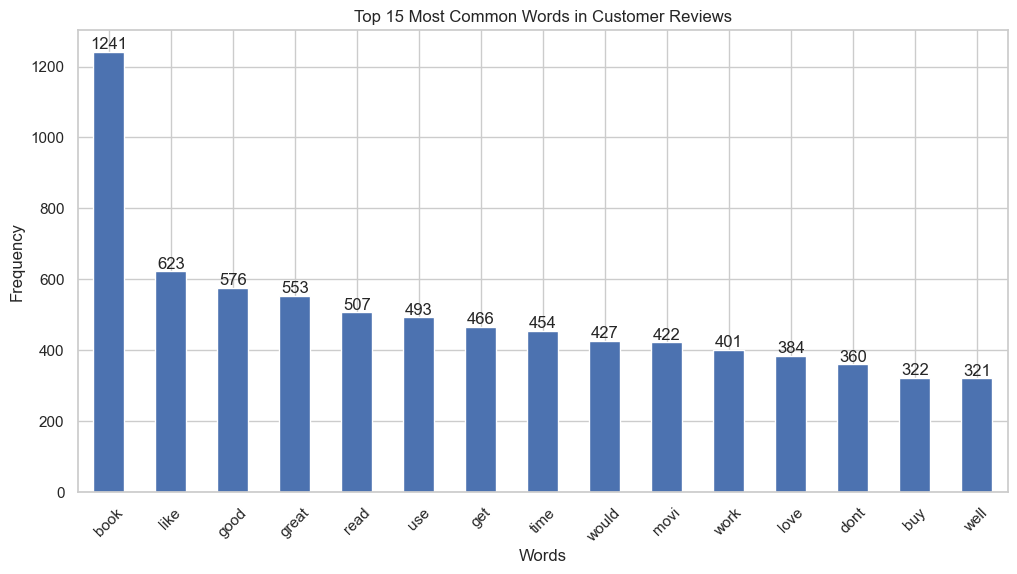

In [50]:
from nltk import ngrams
from nltk.probability import FreqDist
from nltk.corpus import stopwords  # Import stopwords from NLTK corpus

# split the text of content column
words = []
for word in df['new_review']:
    words.extend(word.split())

# Filter out the additional words you highlighted earlier
custom_stopwords = ['ha', 'wa', 'thi', 'one', 'veri', 'hi', 'onli']
stopwords_list = list(stopwords.words('english'))  # Convert stopwords to a list
stopwords_list.extend(custom_stopwords)  # Add custom stopwords

new_words = [word for word in words if word not in stopwords_list]

# Create a frequency distribution of words
freq_dist = FreqDist(new_words).most_common(15)

# creating a dataframe of the the top 20 words with their distribution
all_freqdist = pd.Series(dict(freq_dist))
# print(all_freqdist)

# Plot the frequency distribution
plt.figure(figsize=(12, 6))
bar_plot = all_freqdist.plot(kind='bar')
plt.title('Top 15 Most Common Words in Customer Reviews')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
# Display frequency values on top of each bar
for idx, value in enumerate(all_freqdist):
    bar_plot.text(idx, value, str(value), ha='center', va='bottom')
plt.show();

<Axes: >

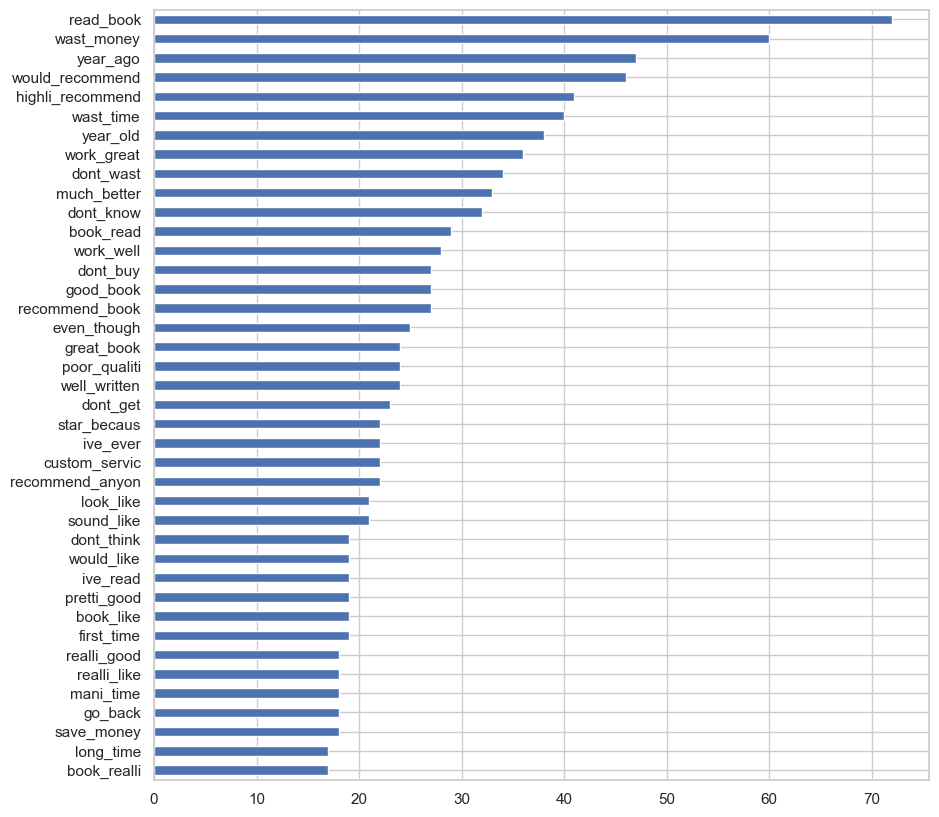

In [52]:
from nltk import ngrams as nltk_ngrams
from nltk.probability import FreqDist
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

def get_freq_dist(new_words, number_of_grams):
    # generate ngrams
    ngram = nltk_ngrams(new_words, number_of_grams)
    
    # create a frequency distribution
    ngram_fd = FreqDist(ngram).most_common(40)
    
    # sort values by highest frequency
    ngram_sorted = {k:v for k, v in sorted(ngram_fd, key=lambda item: item[1])}
    
    # join ngram tokens with '-' and maintain sorting
    ngram_joined = {'_'.join(k):v for k, v in sorted(ngram_fd, key=lambda item: item[1])}
    
    # convert to pandas Series for easy plotting
    ngram_freqdist = pd.Series(ngram_joined)
    #print(ngram_freqdist)
    
    plt.figure(figsize=(10, 10))
    ax = ngram_freqdist.plot(kind='barh')
    return ax

# Call the function
get_freq_dist(new_words, 2)

In [26]:
# Splitting the data into train and test sets
train_review = df.new_review[:1000]
test_review = df.new_review[1000:]
train_data = df.Sentiment[:1000]
test_data = df.Sentiment[1000:]

# Label encoding
label = LabelBinarizer()
train_data_encoded = label.fit_transform(train_data).ravel()
test_data_encoded = label.transform(test_data).ravel()

# Bag of Words (CountVectorizer)
cv = CountVectorizer(min_df=0, max_df=1, binary=False, ngram_range=(1,3))
cv_train = cv.fit_transform(train_review)
cv_test = cv.transform(test_review)

# TF-IDF Vectorizer
tf = TfidfVectorizer(min_df=0, max_df=1, use_idf=True, ngram_range=(1,3))
tf_train = tf.fit_transform(train_review)
tf_test = tf.transform(test_review)

# Logistic Regression Model
lr = LogisticRegression(penalty='l2', max_iter=500, C=1, random_state=42)

# Fit and predict for Bag of Words
lr_bow = lr.fit(cv_train, train_data_encoded)
bow_pred = lr.predict(cv_test)
report_bow = classification_report(test_data_encoded, bow_pred)
print("Logistic Regression Classification Report for Bag of Words:\n", report_bow)
print("----------------------------------------------------------------")

# Fit and predict for TF-IDF
lr_tfidf = lr.fit(tf_train, train_data_encoded)
tf_pred = lr.predict(tf_test)
report_tfidf = classification_report(test_data_encoded, tf_pred)
print("Logistic Regression Classification Report for TF-IDF:\n", report_tfidf)
print("----------------------------------------------------------------")

# Naive Bayes Model
nb = MultinomialNB()

# Fit and predict for TF-IDF with Naive Bayes
nb_tfidf = nb.fit(tf_train, train_data_encoded)
nb_pred = nb.predict(tf_test)
report_nb = classification_report(test_data_encoded, nb_pred)
print("Naive Bayes Classification Report for TF-IDF:\n", report_nb)

Logistic Regression Classification Report for Bag of Words:
               precision    recall  f1-score   support

           0       0.75      0.22      0.34       504
           1       0.54      0.93      0.68       496

    accuracy                           0.57      1000
   macro avg       0.64      0.57      0.51      1000
weighted avg       0.64      0.57      0.51      1000

----------------------------------------------------------------
Logistic Regression Classification Report for TF-IDF:
               precision    recall  f1-score   support

           0       0.66      0.53      0.59       504
           1       0.60      0.73      0.66       496

    accuracy                           0.63      1000
   macro avg       0.63      0.63      0.62      1000
weighted avg       0.63      0.63      0.62      1000

----------------------------------------------------------------
Naive Bayes Classification Report for TF-IDF:
               precision    recall  f1-score   support

In [27]:
# vader
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [28]:
# pip install vaderSentiment

In [29]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize VADER Sentiment Analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to get sentiment label using VADER
def get_vader_sentiment(review):
    scores = analyzer.polarity_scores(review)
    compound_score = scores['compound']
    if compound_score >= 0:
        return 'positive'
    else:
        return 'negative'

# Apply VADER to each review
df['vader_sentiment'] = df['new_review'].apply(get_vader_sentiment)

In [30]:
# Extract true labels and predicted labels
true_labels = df['Sentiment']
predicted_labels = df['vader_sentiment']

# Generate classification report
classification_report_vader = classification_report(true_labels, predicted_labels)

print("Classification Report for VADER predictions:\n", classification_report_vader)

Classification Report for VADER predictions:
               precision    recall  f1-score   support

    negative       0.84      0.43      0.57      1000
    positive       0.62      0.92      0.74      1000

    accuracy                           0.68      2000
   macro avg       0.73      0.68      0.66      2000
weighted avg       0.73      0.68      0.66      2000



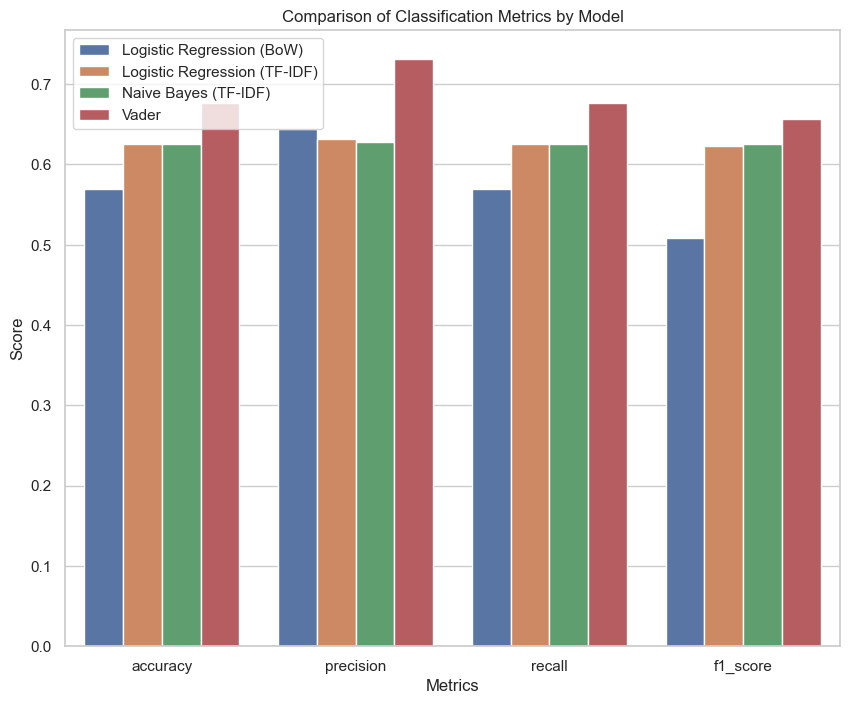

In [31]:
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Function to extract metrics from classification report
def get_metrics(report):
    lines = report.split('\n')
    metrics = {}
    for line in lines[2:-3]:
        if 'accuracy' in line:
            continue
        row_data = ' '.join(line.split()).split(' ')
        if len(row_data) >= 5:
            class_name = row_data[0]
            metrics[class_name] = {
                'precision': float(row_data[1]),
                'recall': float(row_data[2]),
                'f1_score': float(row_data[3]),
                'support': int(row_data[4])
            }
    return metrics

# Calculate overall metrics
def calculate_overall_metrics(y_true, y_pred, model_name):
    report = classification_report(y_true, y_pred, output_dict=True)
    accuracy = accuracy_score(y_true, y_pred)
    precision = report['weighted avg']['precision']
    recall = report['weighted avg']['recall']
    f1_score = report['weighted avg']['f1-score']
    return {
        'model': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score
    }

# Generate predictions and calculate metrics
metrics_bow = calculate_overall_metrics(test_data_encoded, bow_pred, 'Logistic Regression (BoW)')
metrics_tfidf = calculate_overall_metrics(test_data_encoded, tf_pred, 'Logistic Regression (TF-IDF)')
metrics_nb = calculate_overall_metrics(test_data_encoded, nb_pred, 'Naive Bayes (TF-IDF)')
classification_report_vader = calculate_overall_metrics(true_labels, predicted_labels, 'Vader')

# Combine all metrics into a DataFrame
metrics_df = pd.DataFrame([metrics_bow, metrics_tfidf, metrics_nb, classification_report_vader])

# Melt the DataFrame for easier plotting
metrics_melted = metrics_df.melt(id_vars=['model'], value_vars=['accuracy', 'precision', 'recall', 'f1_score'])

# Set plot style
sns.set(style="whitegrid")

# Create the bar plot
plt.figure(figsize=(10, 8))
sns.barplot(x='variable', y='value', hue='model', data=metrics_melted)
plt.title('Comparison of Classification Metrics by Model')
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.legend(loc='best')
plt.show();

In [32]:
# Saving the VADER Sentiment Analysis Logic as a Pickle File
import pickle
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Save the VADER Sentiment Analyzer as a pickle file
analyzer = SentimentIntensityAnalyzer()

with open('vader_analyzer.pkl', 'wb') as f:
    pickle.dump(analyzer, f)

In [33]:
# Create Functions for Text Cleaning and Sentiment Prediction

# Define text cleaning functions
def noiseremover(text):
    if not isinstance(text, str):
        return text
    text = re.sub('<.*?>', ' ', text)
    text = re.sub(r'https?://\S+|www\.\S+', ' ', text)
    text = re.sub('[^a-zA-Z0-9\s]', '', text)
    text = ''.join([i for i in text if not i.isdigit()])
    text = " ".join(filter(None, (re.compile(r'\D*\d').match(word) and '' or word for word in text.split())))
    return text

ps = PorterStemmer()

def stemmer(text):
    return ' '.join([ps.stem(word) for word in text.split()])

def removing_stopwords(text):
    stopwords_list = set(stopwords.words('english'))
    stopwords_list.remove('no')
    stopwords_list.remove('not')
    return ' '.join([word for word in text.split() if word.lower() not in stopwords_list])

#tokenizer = ToktokTokenizer()
#stopwords_list = stopwords.words('english')
#stopwords_list.remove('no')
#stopwords_list.remove('not')

def removing_stopwords(text):
    tokens = tokenizer.tokenize(text)
    tokens = [i.strip() for i in tokens]
    return ' '.join([i for i in tokens if i.lower() not in stopwords_list])

# Function to get sentiment using VADER
def get_vader_sentiment(analyzer, review):
    scores = analyzer.polarity_scores(review)
    return 'positive' if scores['compound'] >= 0 else 'negative'

# Define the sentiment pipeline class
class SentimentPipeline:
    def __init__(self, analyzer):
        self.analyzer = analyzer
    
    def clean_text(self, text):
        text = noiseremover(text)
        text = stemmer(text)
        text = removing_stopwords(text)
        return text
    
    def predict_sentiment(self, text):
        cleaned_text = self.clean_text(text)
        sentiment = get_vader_sentiment(self.analyzer, cleaned_text)
        return sentiment# Text cleaning function
def noiseremover(text):
    if not isinstance(text, str):
        return text
    text = re.sub('<.*?>', ' ', text)
    text = re.sub(r'https?://\S+|www\.\S+', ' ', text)
    text = re.sub('[^a-zA-Z0-9\s]', '', text)
    text = ''.join([i for i in text if not i.isdigit()])
    text = " ".join(filter(None, (re.compile(r'\D*\d').match(word) and '' or word for word in text.split())))
    return text

# Apply stemming
ps = PorterStemmer()

def stemmer(text):
    return ' '.join([ps.stem(word) for word in text.split()])

# Remove stopwords
tokenizer = ToktokTokenizer()
stopwords_list = stopwords.words('english')
stopwords_list.remove('no')
stopwords_list.remove('not')

def removing_stopwords(text):
    tokens = tokenizer.tokenize(text)
    tokens = [i.strip() for i in tokens]
    return ' '.join([i for i in tokens if i.lower() not in stopwords_list])

# Function to get sentiment using VADER
def get_vader_sentiment(analyzer, review):
    scores = analyzer.polarity_scores(review)
    return 'positive' if scores['compound'] >= 0 else 'negative'

In [34]:
# Load the saved VADER Sentiment Analyzer
with open('vader_analyzer.pkl', 'rb') as f:
    vader_analyzer = pickle.load(f)
    
# Initialize the sentiment pipeline
pipeline = SentimentPipeline(vader_analyzer)

In [35]:
# Load the new dataset
new_reviews = pd.read_csv(r"all_parsed_reviews.csv")

# Rename the column for consistency
new_reviews.rename(columns={'Feedback_translated': 'cleaned_review'}, inplace=True)

# Handle NaN values and ensure all entries in 'cleaned_review' are strings
new_reviews['cleaned_review'] = new_reviews['cleaned_review'].fillna('').astype(str)

# Predict sentiment for each review and add it as a new column
new_reviews['Predicted_Sentiment'] = new_reviews['cleaned_review'].apply(pipeline.predict_sentiment)

# Save the updated dataset to a new CSV file
new_reviews.to_csv(r'C:\Users\hp\Desktop\!0Alytics Internship\test_dataset_with_predictions2.csv', index=False)

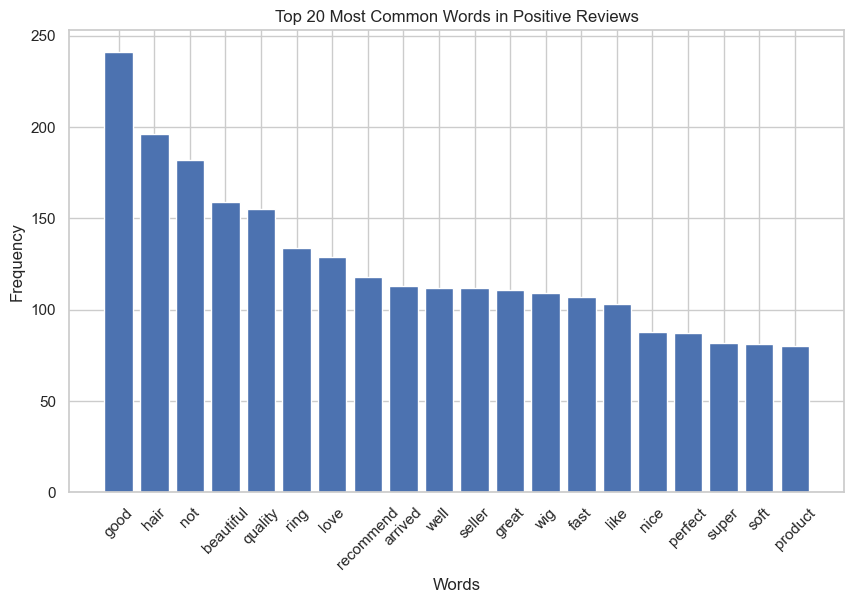

In [37]:
from collections import Counter
# Step 1: Filter positive reviews
positive_reviews = new_reviews[new_reviews['Predicted_Sentiment'] == 'positive']
negative_reviews = new_reviews[new_reviews['Predicted_Sentiment'] == 'negative']

# Step 2: Combine all cleaned_review texts into a single string
positive_text = ' '.join(positive_reviews['cleaned_review'])
negative_text = ' '.join(negative_reviews['cleaned_review'])

# Step 3: Tokenize the combined text
tokens = tokenizer.tokenize(positive_text)
tokens = [i.strip().lower() for i in tokens]
filtered_tokens = [i for i in tokens if i not in stopwords_list and i.isalpha()]

# Step 4: Plot frequency distribution
def plot_freq_dist(filtered_tokens, top_n=10):
    freq_dist = Counter(filtered_tokens)
    common_words = freq_dist.most_common(top_n)
    
    x, y = zip(*common_words)
    plt.figure(figsize=(10, 6))
    plt.bar(x, y)
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.title(f'Top {top_n} Most Common Words in Positive Reviews')
    plt.xticks(rotation=45)
    plt.show()

plot_freq_dist(filtered_tokens, top_n=20)  # Adjust top_n as needed

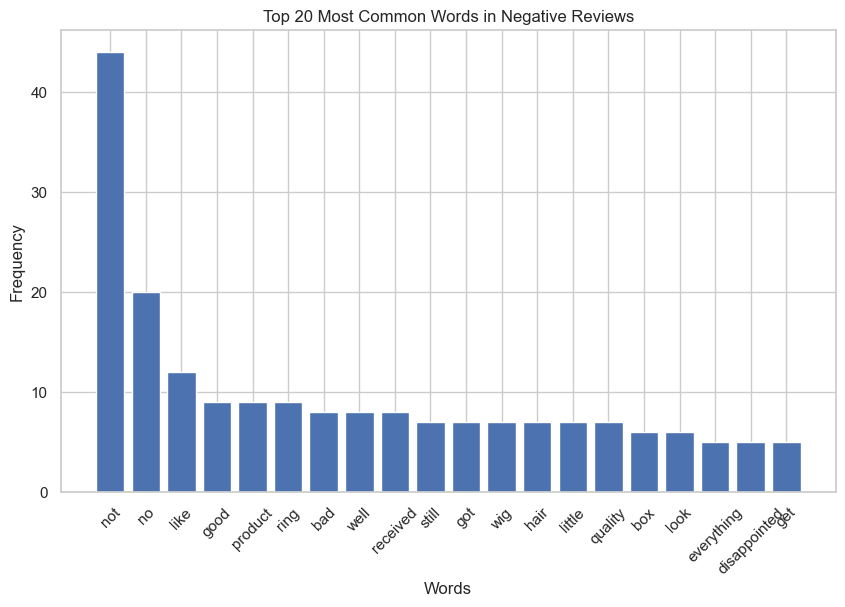

In [40]:
from collections import Counter
# Step 1: Filter positive reviews
negative_reviews = new_reviews[new_reviews['Predicted_Sentiment'] == 'negative']

# Step 2: Combine all cleaned_review texts into a single string
negative_text = ' '.join(negative_reviews['cleaned_review'])

# Step 3: Tokenize the combined text
tokens = tokenizer.tokenize(negative_text)
tokens = [i.strip().lower() for i in tokens]
filtered_tokens = [i for i in tokens if i not in stopwords_list and i.isalpha()]

# Step 4: Plot frequency distribution
def plot_freq_dist(filtered_tokens, top_n=10):
    freq_dist = Counter(filtered_tokens)
    common_words = freq_dist.most_common(top_n)
    
    x, y = zip(*common_words)
    plt.figure(figsize=(10, 6))
    plt.bar(x, y)
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.title(f'Top {top_n} Most Common Words in Negative Reviews')
    plt.xticks(rotation=45)
    plt.show()

plot_freq_dist(filtered_tokens, top_n=20)  # Adjust top_n as needed

In [41]:
new_reviews.head()

,Rating,cleaned_review,Predicted_Sentiment
0,100,Very good packaging well protected but not yet...,positive
1,60,"lights are extremely bright, we used 1.2v batt...",positive
2,100,I like it very much for my son. It is as the d...,positive
3,100,"corresponds to the description, fast delivery,...",positive
4,100,As described. Good quality. Batteries not incl...,positive


In [42]:
# Convert ratings to sentiments (assuming the ratings column is named 'Ratings')
new_reviews['Rating_Sentiment'] = new_reviews['Rating'].apply(lambda x: 'positive' if x > 60 else 'negative')

# Compare predicted sentiment with rating-based sentiment
true_labels = new_reviews['Rating_Sentiment']
predicted_labels = new_reviews['Predicted_Sentiment']

# Calculate performance metrics
accuracy = accuracy_score(true_labels, predicted_labels)
conf_matrix = confusion_matrix(true_labels, predicted_labels)
class_report = classification_report(true_labels, predicted_labels)

print("Accuracy:", accuracy)

Accuracy: 0.8881226053639847


Confusion Matrix:
 [[  35  101]
 [  45 1124]]


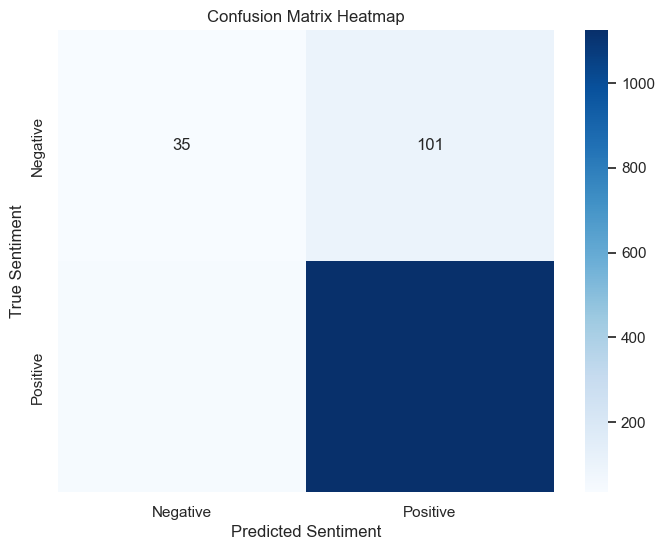

In [43]:
print("Confusion Matrix:\n", conf_matrix)
# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Sentiment')
plt.ylabel('True Sentiment')
plt.title('Confusion Matrix Heatmap')
plt.show();

In [44]:
print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

    negative       0.44      0.26      0.32       136
    positive       0.92      0.96      0.94      1169

    accuracy                           0.89      1305
   macro avg       0.68      0.61      0.63      1305
weighted avg       0.87      0.89      0.87      1305



In [45]:
# Save the new dataset with all columns
new_reviews.to_csv(r'C:\Users\hp\Desktop\!0Alytics Internship\test_dataset_with_predictions2.csv', index=False)

In [46]:
# Output the head of the new dataframe for verification
new_reviews.head()

,Rating,cleaned_review,Predicted_Sentiment,Rating_Sentiment
0,100,Very good packaging well protected but not yet...,positive,positive
1,60,"lights are extremely bright, we used 1.2v batt...",positive,negative
2,100,I like it very much for my son. It is as the d...,positive,positive
3,100,"corresponds to the description, fast delivery,...",positive,positive
4,100,As described. Good quality. Batteries not incl...,positive,positive


In [47]:
new_reviews.Predicted_Sentiment.value_counts()


Predicted_Sentiment
positive    1225
negative      80
Name: count, dtype: int64

In [48]:
new_reviews.cleaned_review[2]

'I like it very much for my son. It is as the description, you just have to put batteries. Thank you'